# EDA, Text, Processing, and Feature Engineering

In [1]:
# custom functions for this project
from functions import *

# dataframe libraries
import pandas as pd
import numpy as np

# graphing libraries
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_style('ticks')
from wordcloud import WordCloud

# text processing
import nltk
from nltk import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.probability import FreqDist
from nltk.stem import WordNetLemmatizer 
from textblob import TextBlob as tb
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim import matutils, models
import scipy.sparse
import pronouncing

# miscellany
import re
import string
from collections import Counter
import time
import gzip
import pickle

# reload functions/libraries when edited
%load_ext autoreload
%autoreload 2

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

# increase column width of dataframe
pd.set_option('max_colwidth', 150)

### Load in DataFrame

In [2]:
df = pd.read_csv('data/poetry_foundation_raw_rescrape.csv', index_col=0)
df.shape

(4626, 7)

In [3]:
df.genre.value_counts()

modern                            1279
victorian                          643
romantic                           398
imagist                            356
new_york_school                    264
black_mountain                     257
new_york_school_2nd_generation     192
language_poetry                    192
confessional                       176
black_arts_movement                165
georgian                           160
objectivist                        159
harlem_renaissance                 148
beat                               147
fugitive                            90
Name: genre, dtype: int64

In [4]:
# sort genres into umbrella genres
conditions = [
    df.genre == 'victorian', df.genre == 'romantic',
    df.genre == 'new_york_school', df.genre == 'new_york_school_2nd_generation', df.genre == 'confessional',
        df.genre == 'beat', df.genre == 'harlem_renaissance', df.genre == 'black_arts_movement',
    df.genre == 'imagist', df.genre == 'black_mountain', df.genre == 'language_poetry', df.genre == 'objectivist',
    df.genre == 'georgian', df.genre == 'fugitive'
]

# name umbrella genres, prepare 'other' to be dropped
choices = [
    'pre_1900', 'pre_1900',
    'metropolitan', 'metropolitan', 'metropolitan', 'metropolitan', 'metropolitan', 'metropolitan',
    'avant_garde', 'avant_garde', 'avant_garde', 'avant_garde',
    'other', 'other'
]

# convert data, leaving 'modern' untouched
df['umbrella_genres'] = np.select(conditions, choices, df.genre)

In [5]:
df.umbrella_genres.value_counts()

modern          1279
metropolitan    1092
pre_1900        1041
avant_garde      964
other            250
Name: umbrella_genres, dtype: int64

In [6]:
# drop 'other' genres
df = df[df.umbrella_genres != 'other']
# drop former genre column
df.drop(columns=['genre'], inplace=True)
# rename umbrella genres as genre column
df.rename(columns={'umbrella_genres': 'genre'}, inplace=True)
# rest the index
df.reset_index(drop=True, inplace=True)
df.shape

(4376, 7)

#### Saving to CSV converts the poem_lines lists into a string, so we'll use our destringify function to convert it back to a list format.

In [7]:
df.loc[2,'poem_lines']

"['At 1:03 in the morning a fart', '\\r smells like a marriage between', '\\r an avocado and a fish head.', '', '\\r I have to get out of bed', '\\r to write this down without', '\\r    my glasses on.', '']"

In [8]:
df['poem_lines'] = df['poem_lines'].apply(destringify)
df.loc[2,'poem_lines']

['At 1:03 in the morning a fart',
 '\r smells like a marriage between',
 '\r an avocado and a fish head.',
 '',
 '\r I have to get out of bed',
 '\r to write this down without',
 '\r    my glasses on.',
 '']

#### Let's look at our class imbalance.

In [9]:
# number of poems per genre
df.genre.value_counts()

modern          1279
metropolitan    1092
pre_1900        1041
avant_garde      964
Name: genre, dtype: int64

In [10]:
# percentage of total poems by genre
df.genre.value_counts(normalize=True)

modern          0.292276
metropolitan    0.249543
pre_1900        0.237888
avant_garde     0.220293
Name: genre, dtype: float64

In [11]:
# cumulative percentage of total poems by genre
df.genre.value_counts(normalize=True).cumsum()

modern          0.292276
metropolitan    0.541819
pre_1900        0.779707
avant_garde     1.000000
Name: genre, dtype: float64

In [12]:
# number of unique poets per genre
{genre:len(poets) for genre,poets in df.groupby('genre').poet.unique().items()}

{'avant_garde': 37, 'metropolitan': 81, 'modern': 54, 'pre_1900': 106}

## EDA/Feature Engineering
### Number of lines column -- first clean up the lines, then count them

In [13]:
# see what the lines look like before cleaning
df.loc[2,'poem_lines']

['At 1:03 in the morning a fart',
 '\r smells like a marriage between',
 '\r an avocado and a fish head.',
 '',
 '\r I have to get out of bed',
 '\r to write this down without',
 '\r    my glasses on.',
 '']

In [14]:
# create column using custom function
df['clean_lines'] = df.poem_lines.apply(line_cleaner)

In [15]:
# check our work
df.loc[2,'clean_lines']

['At 1:03 in the morning a fart',
 'smells like a marriage between',
 'an avocado and a fish head.',
 'I have to get out of bed',
 'to write this down without',
 'my glasses on.']

In [16]:
# create number of lines column
df['num_lines'] = df.clean_lines.apply(lambda x: len(x))

In [17]:
# check our work
df.loc[0,'num_lines']

4

In [18]:
# number of lines stats as a whole
df.num_lines.describe()

count    4376.000000
mean       35.506170
std        58.407807
min         1.000000
25%        14.000000
50%        21.000000
75%        32.000000
max       892.000000
Name: num_lines, dtype: float64

In [19]:
# number of lines stats by genre
df.groupby('genre').num_lines.describe().T

genre  avant_garde  metropolitan       modern     pre_1900
count   964.000000   1092.000000  1279.000000  1041.000000
mean     29.629668     35.670330    23.663018    55.326609
std      37.112817     42.320276    33.821979    95.882525
min       1.000000      1.000000     1.000000     4.000000
25%      14.000000     16.000000    12.500000    14.000000
50%      22.000000     24.000000    18.000000    24.000000
75%      27.000000     36.000000    24.000000    51.000000
max     476.000000    456.000000   605.000000   892.000000

### Number of lines -- Boxplot

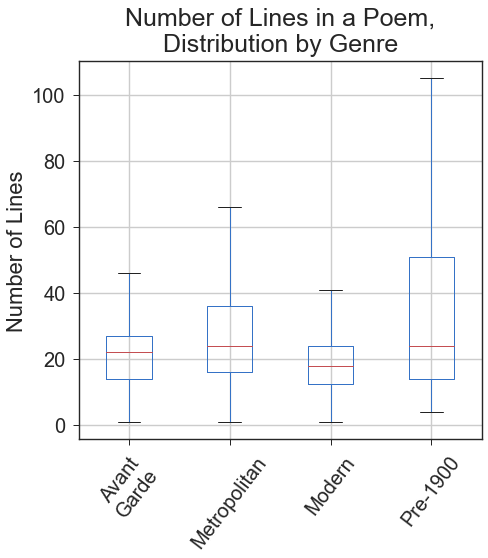

In [33]:
# set a style
sns.set_style('ticks')

# plot the graph
df.boxplot('num_lines', 'genre', showfliers=False, figsize=(7,7))

# prettify the graph
plt.title('Number of Lines in a Poem,\nDistribution by Genre', fontsize=25, pad=10)
plt.suptitle('')
plt.xlabel('')
# plt.xlabel('Poetry Genre', fontsize=22, labelpad=10)
plt.ylabel('Number of Lines', fontsize=22, labelpad=5)

# obtain x-tick labels and their locations
locs, labels = plt.xticks()
# prettify the labels
labels_pretty = [label.get_text().replace('_', '\n').title() for label in list(labels)]
labels_pretty[-1] = 'Pre-1900'

# plot the labels
plt.xticks(ticks=locs, labels=labels_pretty, rotation=52.5, fontsize=20)
plt.yticks(fontsize=20);

#### Some promise here, though the medians look fairly similar
### Number of words column

In [22]:
# create column using custom word counting function
df['num_words'] = df.clean_lines.apply(word_counter)

In [23]:
# number of words stats as a whole
df.num_words.describe()

count    4376.000000
mean      233.031536
std       436.410862
min         2.000000
25%        82.000000
50%       124.000000
75%       210.000000
max      7405.000000
Name: num_words, dtype: float64

In [24]:
# number of words stats by genre
df.groupby('genre').num_words.describe().T

genre  avant_garde  metropolitan       modern     pre_1900
count   964.000000   1092.000000  1279.000000  1041.000000
mean    156.840249    246.586081   149.672400   391.785783
std     209.368921    395.192970   212.247054   708.561849
min       6.000000      2.000000     4.000000    18.000000
25%      60.000000    100.000000    73.000000   108.000000
50%      97.000000    151.500000   111.000000   163.000000
75%     157.000000    244.000000   158.000000   350.000000
max    2264.000000   6997.000000  3888.000000  7405.000000

### Word count -- Boxplot

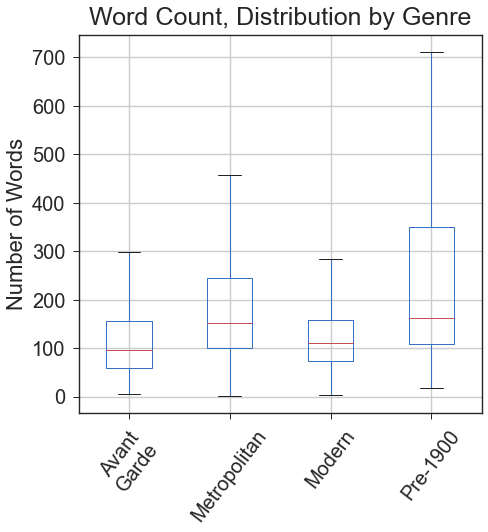

In [25]:
# plot the graph
df.boxplot('num_words', 'genre', showfliers=False, figsize=(7,7))

# prettify the graph
plt.title('Word Count, Distribution by Genre', fontsize=25, pad=10)
plt.suptitle('')
plt.xlabel('')
# plt.xlabel('Poetry Genre', fontsize=22, labelpad=10)
plt.ylabel('Number of Words', fontsize=22, labelpad=5)

# obtain x-tick labels and their locations
locs, labels = plt.xticks()
# prettify the labels
labels_pretty = [label.get_text().replace('_', '\n').title() for label in list(labels)]
labels_pretty[-1] = 'Pre-1900'

# plot the labels
plt.xticks(ticks=locs, labels=labels_pretty, rotation=52.5, fontsize=20)
plt.yticks(fontsize=20);

#### Similar spread of information to number of lines, but a little more variable

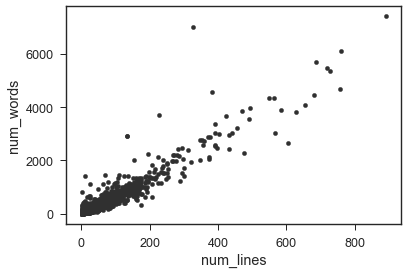

In [26]:
df.plot.scatter('num_lines', 'num_words')

In [27]:
# check correlation
df.num_lines.corr(df.num_words)

0.9459461343928005

#### Indeed they are very correlated.
### Nevertheless, let's create a column with average line length

In [28]:
# create column of average number of words per line
df['avg_len_line'] = df.num_words / df.num_lines

#### Let's look at our new continuous variables, as a whole and by genre

In [29]:
# average length of line stats as a whole
df.avg_len_line.describe()

count    4376.000000
mean        6.790270
std        13.657567
min         1.000000
25%         4.961538
50%         6.200000
75%         7.413690
max       808.000000
Name: avg_len_line, dtype: float64

In [30]:
# average length of line stats by genre
df.groupby('genre').avg_len_line.describe().T

genre  avant_garde  metropolitan       modern     pre_1900
count   964.000000   1092.000000  1279.000000  1041.000000
mean      5.787608      7.620367     6.644311     7.027332
std       9.701428     24.883460     5.948366     1.661236
min       1.000000      1.000000     1.333333     3.375000
25%       3.638258      5.102757     5.187500     5.966102
50%       4.766603      6.342663     6.250000     6.833333
75%       6.169118      7.643908     7.333333     7.833333
max     235.000000    808.000000   139.000000    22.500000

### Average Line Length -- Boxplot

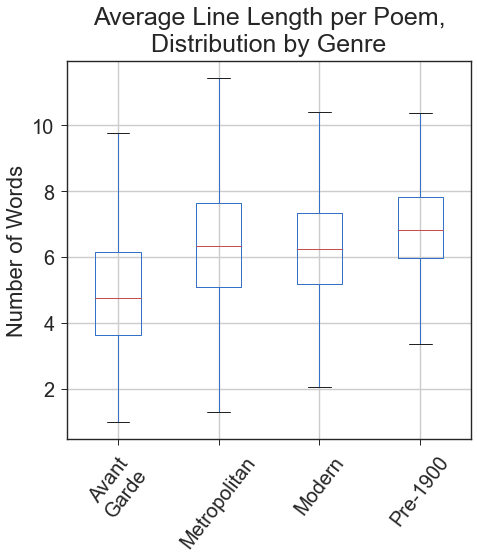

In [31]:
# plot the graph
df.boxplot('avg_len_line', 'genre', showfliers=False, figsize=(7,7))

# prettify the graph
plt.title('Average Line Length per Poem,\nDistribution by Genre', fontsize=25, pad=10)
plt.suptitle('')
plt.xlabel('')
# plt.xlabel('Poetry Genre', fontsize=22, labelpad=10)
plt.ylabel('Number of Words', fontsize=22, labelpad=5)

# obtain x-tick labels and their locations
locs, labels = plt.xticks()
# prettify the labels
labels_pretty = [label.get_text().replace('_', '\n').title() for label in list(labels)]
labels_pretty[-1] = 'Pre-1900'

# plot the labels
plt.xticks(ticks=locs, labels=labels_pretty, rotation=52.5, fontsize=20)
plt.yticks(fontsize=20);

#### Definitely some promise here -- average line length appears to be very telling -- avant-garde clearly has the shortest lines on average, whereas pre-1900 poetry has the longest.
## A look at polarity by genre

In [34]:
# instantiate VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# create a column with the compound polarity score, passing in the raw poem
df['sentiment_polarity_score'] = df['poem_string'].apply(lambda x: analyzer.polarity_scores(x)['compound'])

In [35]:
# may be handy to also have this as a categorical variable
conditions = [
    df.sentiment_polarity_score >= .05,
    df.sentiment_polarity_score <= -.05
]

choices = [
    'positive',
    'negative'
]

df['sentiment_polarity'] = np.select(conditions, choices, 'neutral')

In [36]:
# polarity score stats as a whole
df.sentiment_polarity_score.describe()

count    4376.000000
mean        0.272511
std         0.727446
min        -0.999900
25%        -0.476700
50%         0.599400
75%         0.930000
max         1.000000
Name: sentiment_polarity_score, dtype: float64

In [37]:
# polarity score stats by genre
df.groupby('genre').sentiment_polarity_score.describe().T

genre  avant_garde  metropolitan       modern     pre_1900
count   964.000000   1092.000000  1279.000000  1041.000000
mean      0.235615      0.235699     0.211510     0.420238
std       0.661051      0.752820     0.707653     0.763196
min      -0.998200     -0.999800    -0.998100    -0.999900
25%      -0.361200     -0.601800    -0.508550    -0.327000
50%       0.411800      0.579000     0.461200     0.897800
75%       0.855450      0.926050     0.880950     0.983900
max       0.998100      0.999900     0.999900     1.000000

### Polarity score -- Boxplot

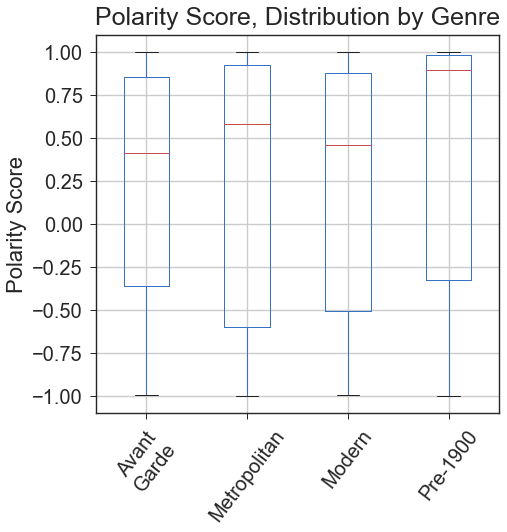

In [38]:
# plot the graph
df.boxplot('sentiment_polarity_score', 'genre', showfliers=False, figsize=(7,7))

# prettify the graph
plt.title('Polarity Score, Distribution by Genre', fontsize=25, pad=10)
plt.suptitle('')
plt.xlabel('')
# plt.xlabel('Poetry Genre', fontsize=22, labelpad=10)
plt.ylabel('Polarity Score', fontsize=22, labelpad=5)

# obtain x-tick labels and their locations
locs, labels = plt.xticks()
# prettify the labels
labels_pretty = [label.get_text().replace('_', '\n').title() for label in list(labels)]
labels_pretty[-1] = 'Pre-1900'

# plot the labels
plt.xticks(ticks=locs, labels=labels_pretty, rotation=52.5, fontsize=20)
plt.yticks(fontsize=20);

#### Pre-1900 poetry is by far the most positive genre of poetry, with avant-garde and modern poetry vying for the least positive poetry.

### Polarity -- Stacked bar chart

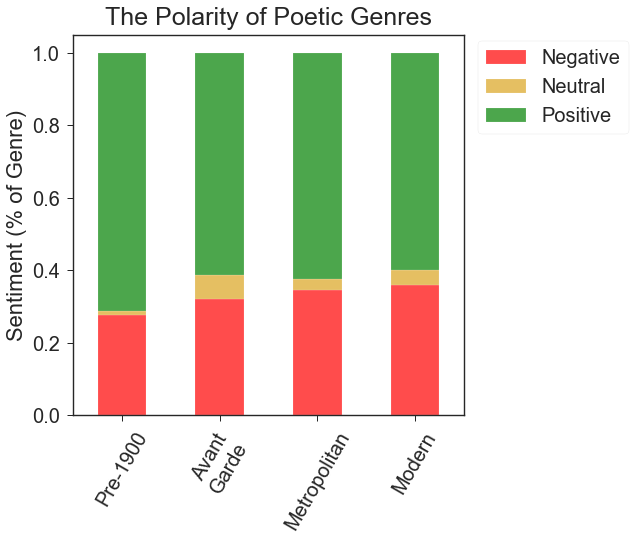

In [39]:
# Proportion of polarity across genre
genre_polarity_dist = df.groupby('genre').sentiment_polarity.value_counts(normalize=True).unstack().sort_values('negative')

# plot the graph
genre_polarity_dist.plot(kind='bar', stacked = True, figsize=(7,7), 
                               color = ['red', 'goldenrod', 'green'], alpha = .70, fontsize=14)

# prettify the graph
plt.title('The Polarity of Poetic Genres', fontsize=25, pad=10)
plt.suptitle('')
plt.xlabel('')
# plt.xlabel('Poetic Genre', fontsize=22, labelpad=10)
plt.ylabel('Sentiment (% of Genre)', fontsize=22, labelpad=5)

# obtain x-tick-labels and their locations
locs, labels = plt.xticks()
# prettify the labels
labels_pretty = [label.get_text().replace('_', '\n').title() for label in list(labels)]
labels_pretty[0] = 'Pre-1900'

# plot the labels and legend
plt.xticks(ticks=locs, labels=labels_pretty, rotation=60, fontsize=20)
plt.yticks(fontsize=20);
plt.legend(['Negative', 'Neutral', 'Positive'], facecolor='white', framealpha=1, bbox_to_anchor=(1.01, 1.01),
          fontsize=20);

#### Polarity differences as a categorical shows that avant-garde poetry has the most neutral poems, though that is still a small percentage of the poems within that genre.

### A look at subjectivity by genre

In [40]:
# create a column with the compound polarity score, passing in the raw poem to TextBlob
df['sentiment_subjectivity_score'] = df['poem_string'].apply(lambda x: tb(x).sentiment.subjectivity)

# subjectivity score stats as a whole
df.sentiment_subjectivity_score.describe()

count    4376.000000
mean        0.476355
std         0.142303
min         0.000000
25%         0.405374
50%         0.484392
75%         0.551910
max         1.000000
Name: sentiment_subjectivity_score, dtype: float64

In [41]:
# subjectivity score stastby genre
df.groupby('genre').sentiment_subjectivity_score.describe().T

genre  avant_garde  metropolitan       modern     pre_1900
count   964.000000   1092.000000  1279.000000  1041.000000
mean      0.464859      0.467886     0.472870     0.500165
std       0.160869      0.134010     0.155394     0.109229
min       0.000000      0.000000     0.000000     0.000000
25%       0.383315      0.400763     0.393127     0.444633
50%       0.466667      0.473782     0.483929     0.504545
75%       0.556942      0.540009     0.558333     0.557018
max       1.000000      1.000000     1.000000     0.950000

### Subjectivity score -- Boxplot

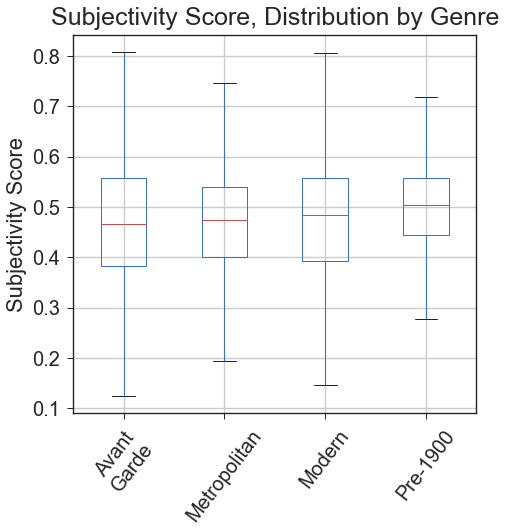

In [42]:
# plot the graph
df.boxplot('sentiment_subjectivity_score', 'genre', showfliers=False, figsize=(7,7))

# prettify the graph
plt.title('Subjectivity Score, Distribution by Genre', fontsize=25, pad=10)
plt.suptitle('')
plt.xlabel('')
# plt.xlabel('Poetry Genre', fontsize=22, labelpad=10)
plt.ylabel('Subjectivity Score', fontsize=22, labelpad=5)

# obtain x-tick labels and their locations
locs, labels = plt.xticks()
# prettify the labels
labels_pretty = [label.get_text().replace('_', '\n').title() for label in list(labels)]
labels_pretty[-1] = 'Pre-1900'

# plot the labels
plt.xticks(ticks=locs, labels=labels_pretty, rotation=52.5, fontsize=20)
plt.yticks(fontsize=20);

#### Subjectivity seems fairly similar across all genres
## DOES IT RHYME?
#### Count the number of end rhymes, i.e. lines where the last word rhymes with another line's last word

In [43]:
# run custom function to count the number of end rhymes in a poem
df['num_end_rhymes'] = df.clean_lines.apply(end_rhyme_counter)

In [44]:
# number of end rhymes stats as a whole
df.num_end_rhymes.describe()

count    4376.000000
mean       23.887797
std       158.125011
min         0.000000
25%         0.000000
50%         3.000000
75%         9.000000
max      4165.000000
Name: num_end_rhymes, dtype: float64

In [45]:
# number of end rhymes stats by genre
df.groupby('genre').num_end_rhymes.describe().T

genre  avant_garde  metropolitan       modern     pre_1900
count   964.000000   1092.000000  1279.000000  1041.000000
mean      3.395228      9.916667     8.302580    76.668588
std      13.434910     49.326754    67.141501   305.356284
min       0.000000      0.000000     0.000000     0.000000
25%       0.000000      0.000000     0.000000     6.000000
50%       0.000000      2.000000     2.000000    12.000000
75%       2.000000      5.000000     6.000000    31.000000
max     281.000000    925.000000  2241.000000  4165.000000

### Number of end rhymes -- Boxplot

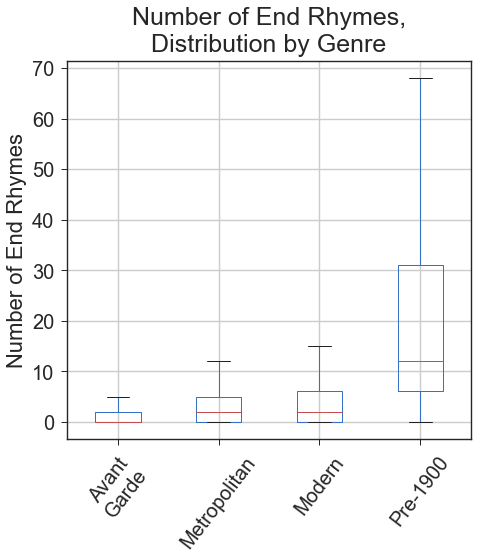

In [101]:
# plot the graph
df.boxplot('num_end_rhymes', 'genre', showfliers=False, figsize=(7,7))

# prettify the graph
plt.title('Number of End Rhymes,\nDistribution by Genre', fontsize=25, pad=10)
plt.suptitle('')
plt.xlabel('')
# plt.xlabel('Poetry Genre', fontsize=22, labelpad=10)
plt.ylabel('Number of End Rhymes', fontsize=22, labelpad=5)

# obtain x-tick labels and their locations
locs, labels = plt.xticks()
# prettify the labels
labels_pretty = [label.get_text().replace('_', '\n').title() for label in list(labels)]
labels_pretty[-1] = 'Pre-1900'

# plot the labels
plt.xticks(ticks=locs, labels=labels_pretty, rotation=52.5, fontsize=20)
plt.yticks(fontsize=20);

#### Pre-1900 poetry is far above the rest, as expected. Similarly unsurprising, avant-garde poetry seems not to have any end rhymes at all.
### Let's see if the ratio of end rhymes to number of lines provides any more insight

In [50]:
# create column of the ratio of end rhymes to the total lines
df['end_rhyme_ratio'] = df.num_end_rhymes / df.num_lines

In [51]:
# end rhyme ratio stats as a whole
df.end_rhyme_ratio.describe()

count    4376.000000
mean        0.284815
std         0.552117
min         0.000000
25%         0.000000
50%         0.115069
75%         0.375000
max        13.846154
Name: end_rhyme_ratio, dtype: float64

In [52]:
# end rhyme ratio stats by genre
df.groupby('genre').end_rhyme_ratio.describe().T

genre  avant_garde  metropolitan       modern     pre_1900
count   964.000000   1092.000000  1279.000000  1041.000000
mean      0.061142      0.161041     0.210880     0.712622
std       0.115344      0.413661     0.263735     0.867569
min       0.000000      0.000000     0.000000     0.000000
25%       0.000000      0.000000     0.000000     0.321839
50%       0.000000      0.062500     0.136364     0.500000
75%       0.078049      0.174871     0.322479     0.821429
max       1.181818      9.700000     3.704132    13.846154

### End rhyme ratio -- Boxplot

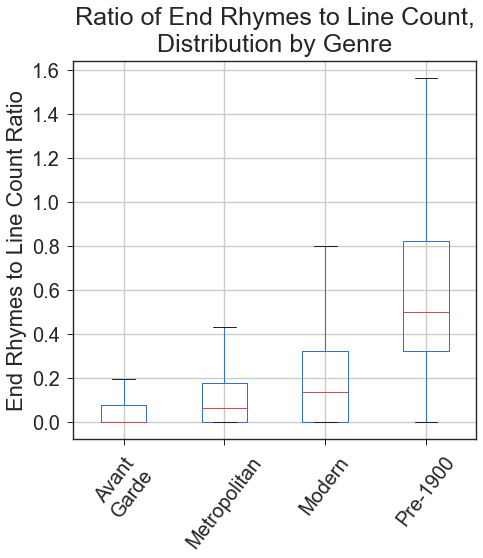

In [53]:
# plot the graph
df.boxplot('end_rhyme_ratio', 'genre', showfliers=False, figsize=(7,7))

# prettify the graph
plt.title('Ratio of End Rhymes to Line Count,\nDistribution by Genre', fontsize=25, pad=10)
plt.suptitle('')
plt.xlabel('')
# plt.xlabel('Poetry Genre', fontsize=22, labelpad=10)
plt.ylabel('End Rhymes to Line Count Ratio', fontsize=22, labelpad=5)

# obtain x-tick labels and their locations
locs, labels = plt.xticks()
# prettify the labels
labels_pretty = [label.get_text().replace('_', '\n').title() for label in list(labels)]
labels_pretty[-1] = 'Pre-1900'

# plot the labels
plt.xticks(ticks=locs, labels=labels_pretty, rotation=52.5, fontsize=20)
plt.yticks(fontsize=20);

#### This plot does seem to show the differences more clearly. Pre-1900 poetry is still in a strong lead, while we now see some separation between Metropolitan and Modern genres.
#### Modern makes a surprise appearance in second place. Everything else makes sense from a poetry standpoint.
### Let's take another, more categorical look -- Usage of End Rhymes Across Genres
#### Feel free to play around with the metric; first I tried separating based on 0 end rhymes vs any number of end rhymes. Increasing the 0 value yielded more interesting results (weeds out some incidental end rhymes). Another tactic is setting a minimum ratio of end rhymes to lines, as seen below.

In [54]:
# create a yes or no column for whether or not end rhymes occur at least 10% of the time
df['end_rhyme'] = np.where(df.end_rhyme_ratio > 0.1, 1, 0)

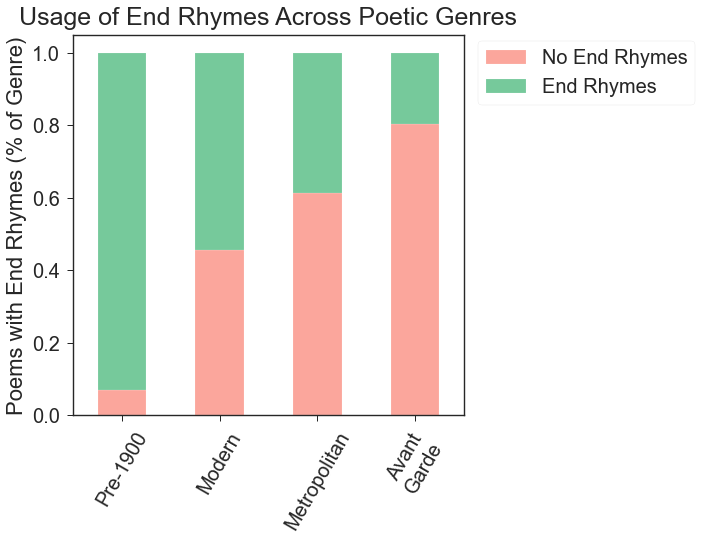

In [55]:
# Proportion of end rhymes across genres
genre_polarity_dist = df.groupby('genre').end_rhyme.value_counts(normalize=True).unstack().sort_values(0)

# plot the graph
genre_polarity_dist.plot(kind='bar', stacked=True, figsize=(7,7), 
                               color=['salmon', 'mediumseagreen'], alpha=.70, fontsize=14)

# prettify the graph
plt.title('Usage of End Rhymes Across Poetic Genres', fontsize=25, pad=10)
plt.suptitle('')
plt.xlabel('')
# plt.xlabel('Poetic Genre', fontsize=22, labelpad=10)
plt.ylabel('Poems with End Rhymes (% of Genre)', fontsize=22, labelpad=5)

# obtain x-tick-labels and their locations
locs, labels = plt.xticks()
# prettify the labels
labels_pretty = [label.get_text().replace('_', '\n').title() for label in list(labels)]
labels_pretty[0] = 'Pre-1900'

# plot the labels and and legends
plt.xticks(ticks=locs, labels=labels_pretty, rotation=60, fontsize=20)
plt.yticks(fontsize=20);
plt.legend(['No End Rhymes', 'End Rhymes'], facecolor='white', framealpha=1, bbox_to_anchor=(1.01, 1.01),
          fontsize=20);

#### Another graph showing similar results more clearly.
## Syllable counting
#### Count the number of total syllables and the average number of syllables per line

In [56]:
# create column using custom function to count a poem's total syllables
df['num_syllables'] = df.clean_lines.apply(syllable_counter)

In [57]:
# total number of syllables stats as a whole
df.num_syllables.describe()

count    4376.000000
mean      281.552102
std       520.802001
min         2.000000
25%        99.000000
50%       149.000000
75%       258.000000
max      8539.000000
Name: num_syllables, dtype: float64

In [58]:
# total number of syllables stats by genre
df.groupby('genre').num_syllables.describe().T

genre  avant_garde  metropolitan       modern     pre_1900
count   964.000000   1092.000000  1279.000000  1041.000000
mean    193.392116    308.586996   181.956216   457.197887
std     258.520400    494.010690   264.836699   828.173653
min       8.000000      2.000000     6.000000    19.000000
25%      73.000000    122.750000    88.000000   126.000000
50%     117.500000    187.000000   132.000000   188.000000
75%     193.000000    307.250000   191.000000   409.000000
max    2958.000000   8539.000000  5058.000000  8236.000000

### Total syllables -- Boxplot

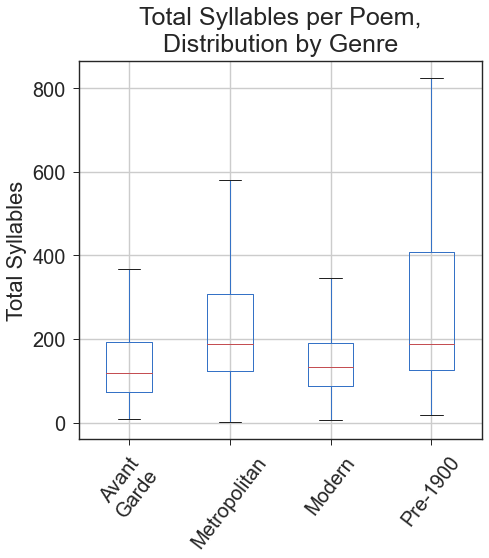

In [59]:
# plot the graph
df.boxplot('num_syllables', 'genre', showfliers=False, figsize=(7,7))

# prettify the graph
plt.title('Total Syllables per Poem,\nDistribution by Genre', fontsize=25, pad=10)
plt.suptitle('')
plt.xlabel('')
# plt.xlabel('Poetry Genre', fontsize=22, labelpad=10)
plt.ylabel('Total Syllables', fontsize=22, labelpad=5)

# obtain x-tick labels and their locations
locs, labels = plt.xticks()

# prettify the labels
labels_pretty = [label.get_text().replace('_', '\n').title() for label in list(labels)]
labels_pretty[-1] = 'Pre-1900'

# plot the labels
plt.xticks(ticks=locs, labels=labels_pretty, rotation=52.5, fontsize=20)
plt.yticks(fontsize=20);

#### Unsurprisingly this looks familar. Number of syllables is highly related to number of words.

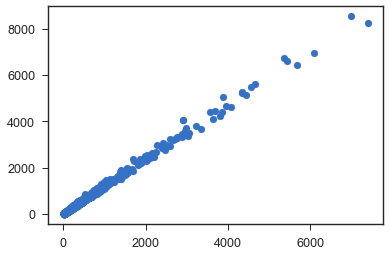

In [60]:
plt.scatter(df.num_words, df.num_syllables)

#### Find the average number of syllables per line

In [61]:
# divide number of syllables by number of words
df['avg_syllables_word'] = df.num_syllables / df.num_words

In [62]:
# average syllables per word stats as a whole
df.avg_syllables_word.describe()

count    4376.000000
mean        1.210480
std         0.088404
min         1.000000
25%         1.151515
50%         1.200990
75%         1.258222
max         1.733333
Name: avg_syllables_word, dtype: float64

In [63]:
# average syllables per word stats by genre
df.groupby('genre').avg_syllables_word.describe().T

genre  avant_garde  metropolitan       modern     pre_1900
count   964.000000   1092.000000  1279.000000  1041.000000
mean      1.227091      1.243109     1.207070     1.165061
std       0.092198      0.093571     0.085424     0.058317
min       1.000000      1.000000     1.000000     1.000000
25%       1.166667      1.180539     1.152721     1.125000
50%       1.220741      1.234771     1.200000     1.160920
75%       1.277778      1.288597     1.250000     1.200331
max       1.607143      1.733333     1.650391     1.486486

### Syllables per word -- Boxplot

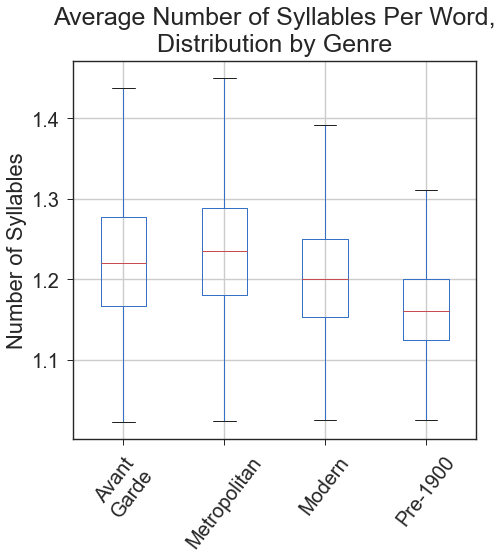

In [64]:
# plot the graph
df.boxplot('avg_syllables_word', 'genre', showfliers=False, figsize=(7,7))

# prettify the graph
plt.title('Average Number of Syllables Per Word,\nDistribution by Genre', fontsize=25, pad=10)
plt.suptitle('')
plt.xlabel('')
# plt.xlabel('Poetry Genre', fontsize=22, labelpad=10)
plt.ylabel('Number of Syllables', fontsize=22, labelpad=5)

# obtain x-tick labels and their locations
locs, labels = plt.xticks()
# prettify the labels
labels_pretty = [label.get_text().replace('_', '\n').title() for label in list(labels)]
labels_pretty[-1] = 'Pre-1900'

# plot the labels
plt.xticks(ticks=locs, labels=labels_pretty, rotation=52.5, fontsize=20)
plt.yticks(fontsize=20);

#### Surprisingly, in my mind at least, Romantic and Victorian (Pre-1900) are among the simplest vocabularies (words with the least amount of syllables).
#### Unsurprisingly, the more intellectual genres (Metropolitan and Avant-Garde) poetries rank among the most complex.

## Text Processing
#### Let's process the text and look at our most frequent words
#### Since I'll be treating the title as part of the poem, combine title and lines

In [65]:
# NOTE: a pesky float ValueError solved by casting str() on values, even though it seems like everything was a string already
df['lines_titled'] = df['title'].apply(lambda x: [str(x)]) + df['clean_lines']
df.loc[2,'lines_titled']

['December 30',
 'At 1:03 in the morning a fart',
 'smells like a marriage between',
 'an avocado and a fish head.',
 'I have to get out of bed',
 'to write this down without',
 'my glasses on.']

In [66]:
# turn each titled poem into a string
df['string_titled'] = df.lines_titled.apply(lambda x: ' '.join(x))
df.loc[2,'string_titled']

'December 30 At 1:03 in the morning a fart smells like a marriage between an avocado and a fish head. I have to get out of bed to write this down without my glasses on.'

#### Prepare a list of stop words

In [67]:
# prepare a list of poet names to add to stop words list, because some may have gotten through in the scraping step
# first prepare a list of names that may also be used as words, so that we DON'T include them in the stop_names list
name_keeps = ['basil', 'bell', 'bill', 'bottoms', 'brooks', 'brown', 'burns', 'butler', 'christian', 'clerk', 'crane',
              'elephant', 'field', 'gallup', 'good', 'guest', 'hands', 'hood', 'hooks', 'hunt', 'hunter', 'knight',
              'lamb', 'lazarus', 'love', 'mare', 'more', 'mark', 'moody', 'peacock', 'pound', 'ransom', 'riding',
              'savage', 'sir', 'white']
# optional = ['bob', 'dick', 'lee', 'maya', 'sappho', 'sexton', 'smith', 'spender', 'twain', 'walker']

stop_names = set()
for poet in df.poet:
    name_split = poet.lower().split()
    for name in name_split:
        if name not in name_keeps:
            stop_names.add(name)
stop_names = list(stop_names)
stop_names[:10]

['oliver',
 'elinor',
 'morley',
 'vincent',
 'landon',
 'wendell',
 'barbara',
 'kipling',
 'brautigan',
 'elmslie']

In [68]:
# start with NLTK stop words
stop_words = stopwords.words('english')

# add any html tags that may have snuck through
stop_words.extend(['em','div', 'href', 'p'])

# add old-timey stop words (modified from Bryan Bumgardner's: https://bryanbumgardner.com/elizabethan-stop-words-for-nlp/)
stop_words.extend(['doth', 'dost', 'ere', 'hast', 'hath', 'hence', 'hither', 'nigh', 'oft', "should'st", 'thither',
                   'tither', 'thee', 'thou', 'thine', 'thy', 'tis', 'twas', 'wast', 'whence', 'wherefore', 'whereto', 
                   'withal', "would'st", 'ye', 'yon', 'yonder'])

# let's include some words found in the initial round of EDA that probably don't give us much meaning
stop_words.extend(['one', 'come', 'like', 'would', 'shall', 'upon', 'yet', 'may', 'could'])

# and don't forget to include the names from above
stop_words.extend(stop_names)

#### Create a clean string column

In [69]:
# create column using custom text processing function
# NOTE: includes lemmatization
df['string_cleaned'] = df.string_titled.apply(lambda x: clean_text(x, stop_words))

In [70]:
# check out an example
print(f'BEFORE:\n{df.iloc[2,-2]}')
print('\n' + '-' * 100 + '\n')
print(f'AFTER:\n{df.iloc[2,-1]}')

BEFORE:
December 30 At 1:03 in the morning a fart smells like a marriage between an avocado and a fish head. I have to get out of bed to write this down without my glasses on.

----------------------------------------------------------------------------------------------------

AFTER:
december morning fart smell marriage avocado fish head get bed write without glass


In [71]:
# check out another example
print(f'BEFORE:\n{df.iloc[4000,-2]}\n')
print('-' * 100)
print(f'\nAFTER:\n{df.iloc[4000,-1]}'')

BEFORE:
A Pict Song Rome never looks where she treads. Always her heavy hooves fall On our stomachs, our hearts or our heads; And Rome never heeds when we bawl. Her sentries pass on—that is all, And we gather behind them in hordes, And plot to reconquer the Wall, With only our tongues for our swords. We are the Little Folk—we! Too little to love or to hate. Leave us alone and you’ll see How we can drag down the State! We are the worm in the wood! We are the rot at the root! We are the taint in the blood! We are the thorn in the foot! Mistletoe killing an oak— Rats gnawing cables in two— Moths making holes in a cloak— How they must love what they do! Yes—and we Little Folk too, We are busy as they— Working our works out of view— Watch, and you’ll see it some day! No indeed! We are not strong, But we know Peoples that are. Yes, and we’ll guide them along To smash and destroy you in War! We Yes, we have always been slaves, But you—you will die of the shame, And then we shall dance on your

### Total word count, vocabulary, and most frequent words
#### Let's see how many words and unique words we have in the dataset (before processing the text)

In [72]:
# join all pre-processed poems into one string
big_string = ' '.join(df.string_titled)
big_string[:1000]

'At the California Institute of Technology I don’t care how God-damn smart these guys are: I’m bored. It’s been raining like hell all day long and there’s nothing to do. A Boat O beautiful was the werewolf in his evil forest. We took him to the carnival and he started crying when he saw the Ferris wheel. Electric green and red tears flowed down his furry cheeks. He looked like a boat out on the dark water. December 30 At 1:03 in the morning a fart smells like a marriage between an avocado and a fish head. I have to get out of bed to write this down without my glasses on. The Double-Bed Dream Gallows Driving through hot brushy country in the late autumn, I saw a hawk crucified on a barbed-wire fence. I guess as a kind of advertisement to other hawks, saying from the pages of a leading women’s magazine, “She’s beautiful, but burn all the maps to your body. I’m not here of my own choosing.” Haiku Ambulance A piece of green pepper fell off the wooden salad bowl: so what? I Feel Horrible. S

In [73]:
# split string into all words in corpus
all_words = big_string.split()

# total words
len(all_words)

1034736

In [74]:
# unique words (vocabulary)
len(list(set(all_words)))

110732

#### Now let's do the same on our cleaned text (after lemmatizing and removing stop words)

In [75]:
# join all processed poems into one string
big_string2 = ' '.join(df.string_cleaned)
big_string2[:1000]

'california institute technology care god damn smart guy bore rain hell day long nothing boat beautiful werewolf evil forest take carnival start cry saw ferris wheel electric green red tear flow furry cheek look boat dark water december morning fart smell marriage avocado fish head get bed write without glass double bed dream gallows drive hot brushy country late autumn saw hawk crucify barbed wire fence guess kind advertisement hawk say page lead woman magazine beautiful burn map body choose haiku ambulance piece green pepper fell wooden salad bowl feel horrible feel horrible love wander around house sew machine finish sew turd garbage lid mating saliva girl green mini skirt pretty walk street businessman stop turn stare look moldy refrigerator people america pill versus springhill mine disaster take pill mine disaster think people lose inside poker star star look poker game mountain eastern oregon three men play sheepherder two pair others nothing private eye lettuce three crate priv

In [76]:
# split string into all words in corpus
all_words2 = big_string2.split()

# total words
len(all_words2)

517825

In [77]:
# unique words (vocabulary)
len(list(set(all_words2)))

33100

#### Look at most frequent words

In [113]:
# create dictionary of word counts
fdist = FreqDist(all_words2)
fdist

FreqDist({'love': 2996, 'say': 2528, 'day': 2345, 'see': 2275, 'make': 2260, 'eye': 2091, 'know': 2013, 'night': 1977, 'life': 1975, 'man': 1911, ...})

In [114]:
# convert word counts to dataframe
fdist_df = pd.DataFrame(data=fdist.values(), index=fdist.keys(), columns=['word_count'])
fdist_df = fdist_df.sort_values('word_count', ascending=False)

In [115]:
# look at the top 25 words in the processed corpus
top_25 = fdist_df.iloc[:25,:]
top_25

word_count
love         2996
say          2528
day          2345
see          2275
make         2260
eye          2091
know         2013
night        1977
life         1975
man          1911
time         1856
old          1764
light        1753
heart        1683
thing        1520
hand         1495
look         1471
still        1429
long         1424
take         1341
never        1333
world        1301
white        1283
sea          1266
face         1250

### Most frequent words -- Bar chart

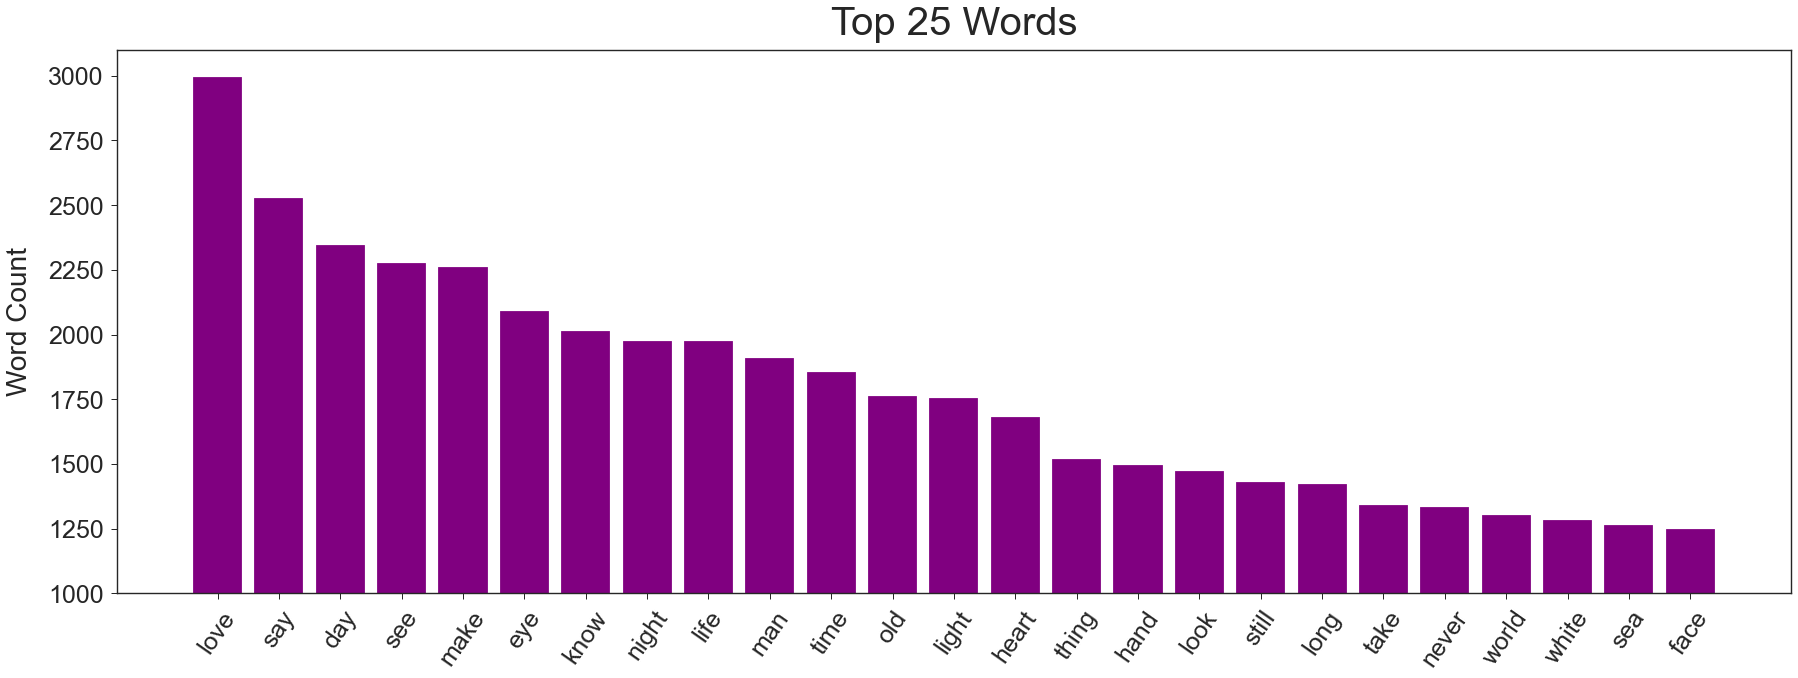

In [116]:
# create labels and prettify the plot
plt.figure(figsize=(30,10))
plt.title('Top 25 Words', fontsize=40, pad=15)
plt.ylabel('Word Count', fontsize=28, labelpad=15)
plt.xticks(rotation=55, fontsize=25)
plt.yticks(fontsize=25)
plt.ylim(bottom=1000, top=3100)

# plot top 25 words
plt.bar(top_25.index, top_25.word_count, color='purple');

# plt.savefig('charts/top_25_words.png', dpi = 100)

## Most frequent words by genre

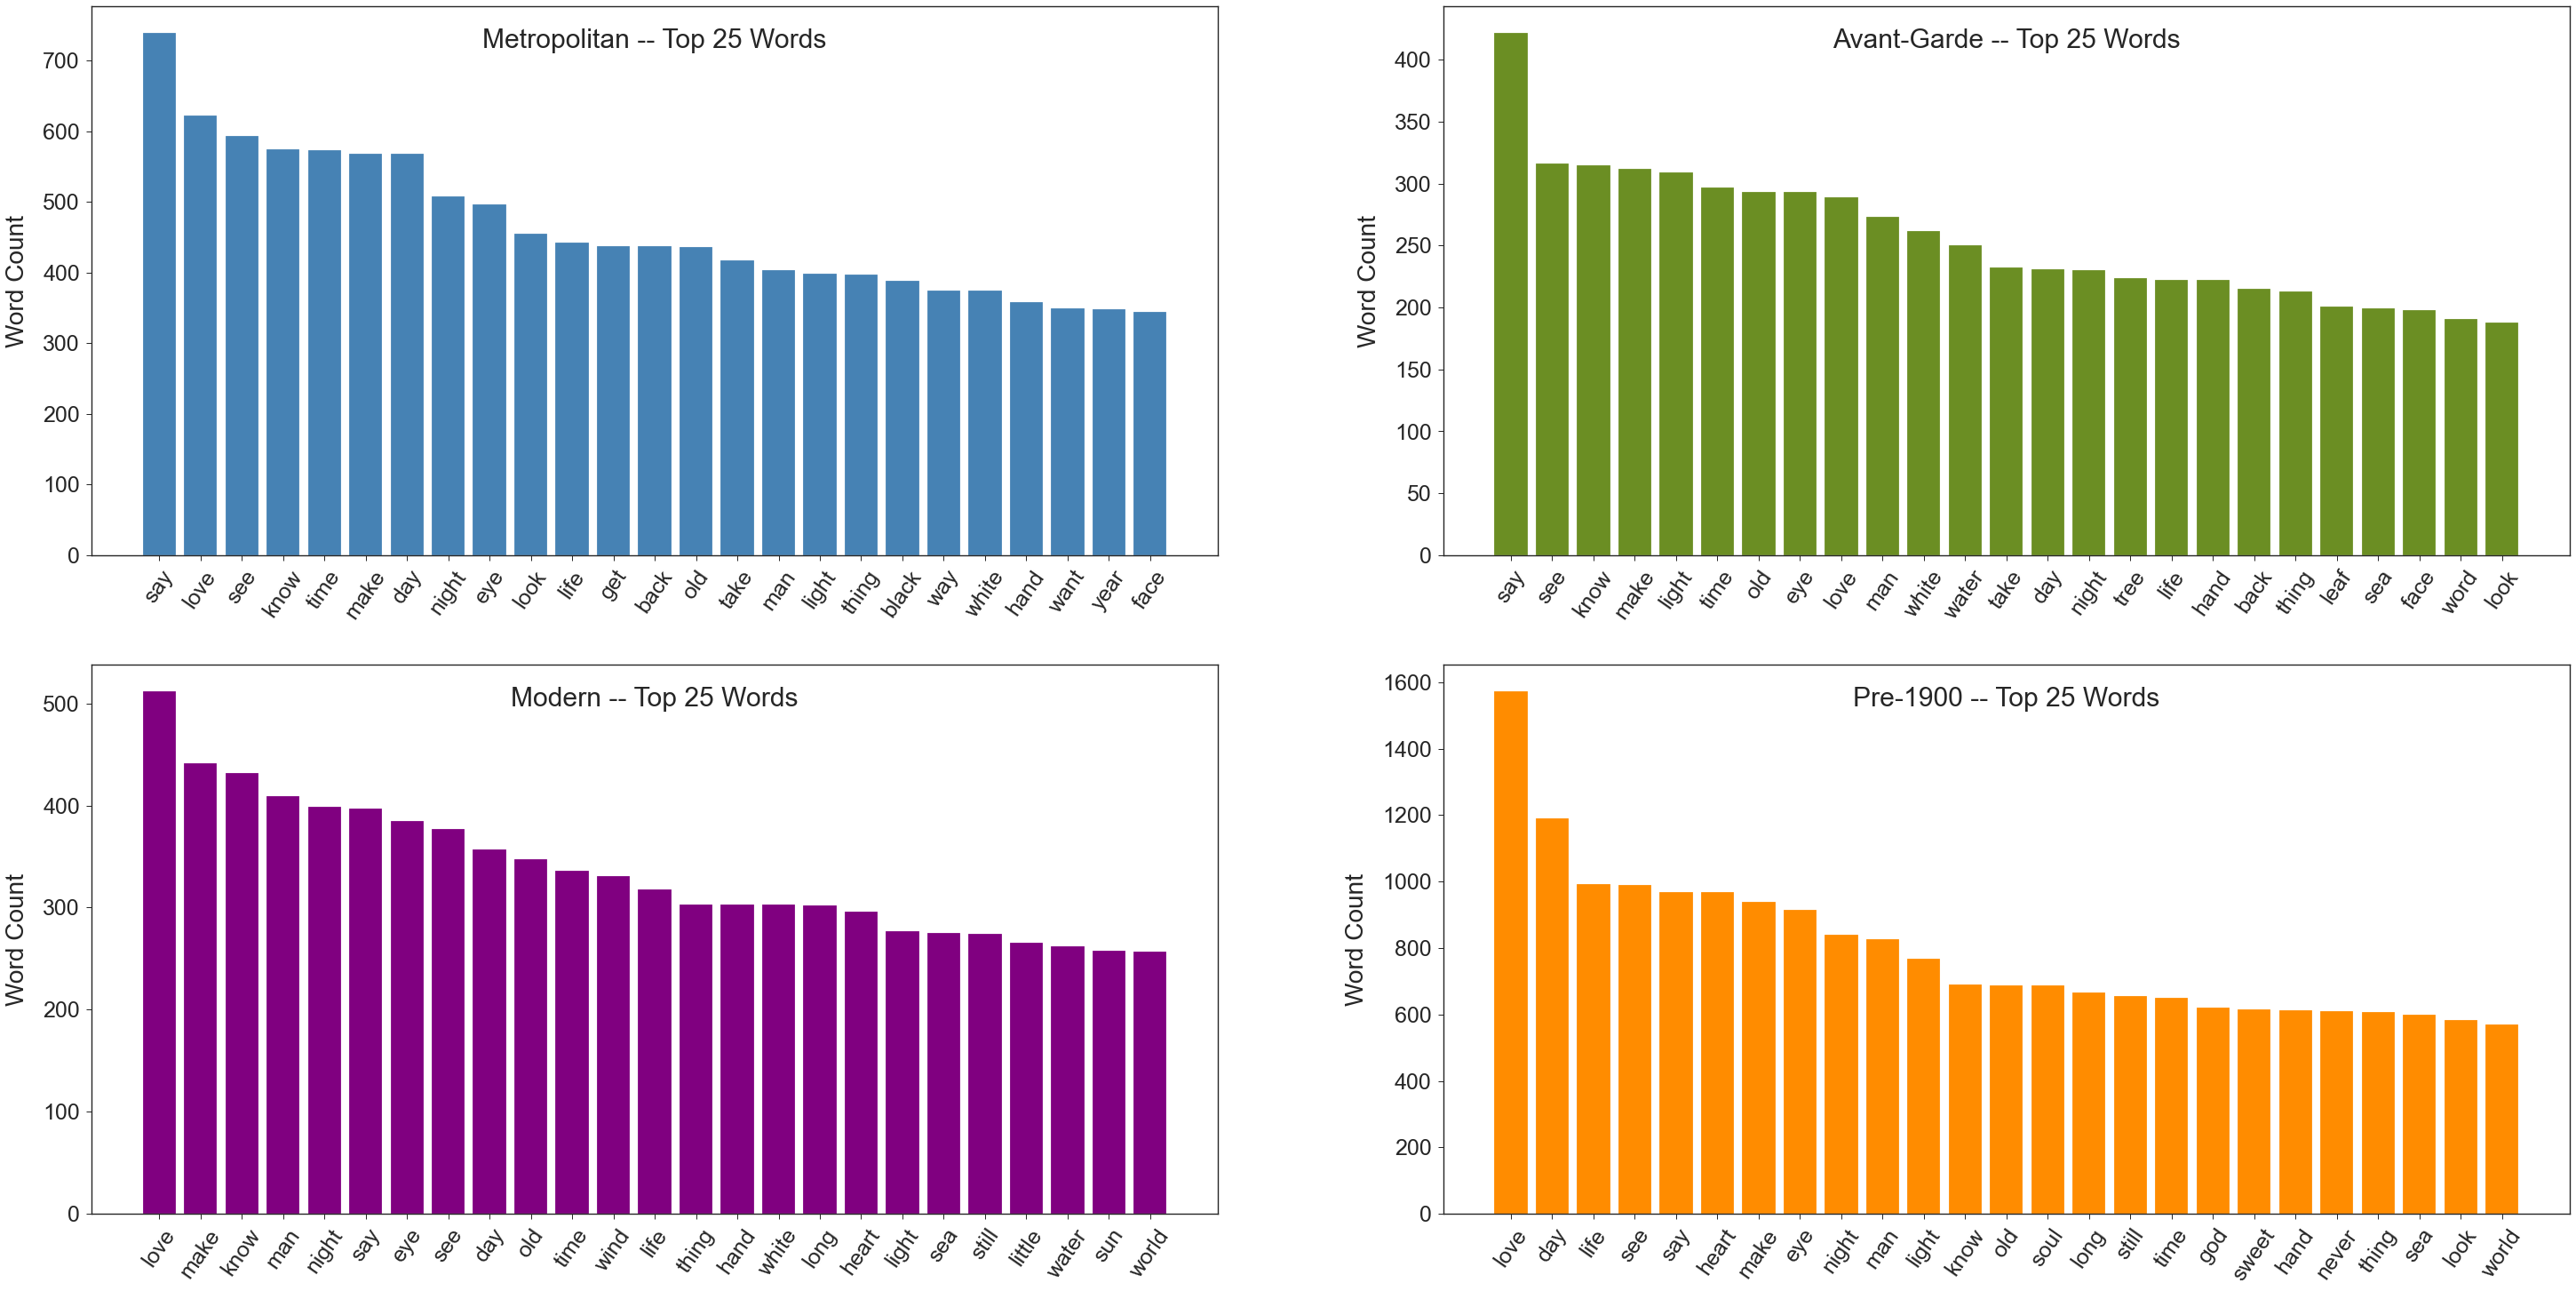

In [110]:
plt.figure(figsize=(50,25))

genres = list(df.genre.unique())

for i, genre in enumerate(genres):
    # create a series of processed poem strings
    genre_string_series = df[df.genre == genre].string_cleaned
    
    # convert the series to one big string
    genre_big_string = ' '.join(genre_string_series)
    
    # split the big string so we get all words in the genre
    genre_words = genre_big_string.split()
    
    # create dictionary of word counts
    fdist = FreqDist(genre_words)
    
    # convert word counts to dataframe
    fdist_df = pd.DataFrame(data=fdist.values(), index=fdist.keys(), columns=['word_count'])
    fdist_df = fdist_df.sort_values('word_count', ascending=False)
    
    # look at the top 25 words for the genre
    top_25 = fdist_df.iloc[:25,:]

    # set dimension of plots
    nrows = 2
    ncols = 2

    # list of colors
    colors = ['steelblue', 'olivedrab', 'purple', 'darkorange']
    
    # plot
    plt.subplot(nrows, ncols, i+1)
    plt.title(f'{genre.title().replace("_", "-")} -- Top 25 Words', fontsize=30, pad=15, x=0.5, y=0.9)
    plt.ylabel('Word Count', fontsize=28, labelpad=15)
    plt.xticks(rotation=55, fontsize=25)
    plt.yticks(fontsize=25)
    plt.bar(top_25.index, top_25.word_count, color=colors[i])

### Word clouds

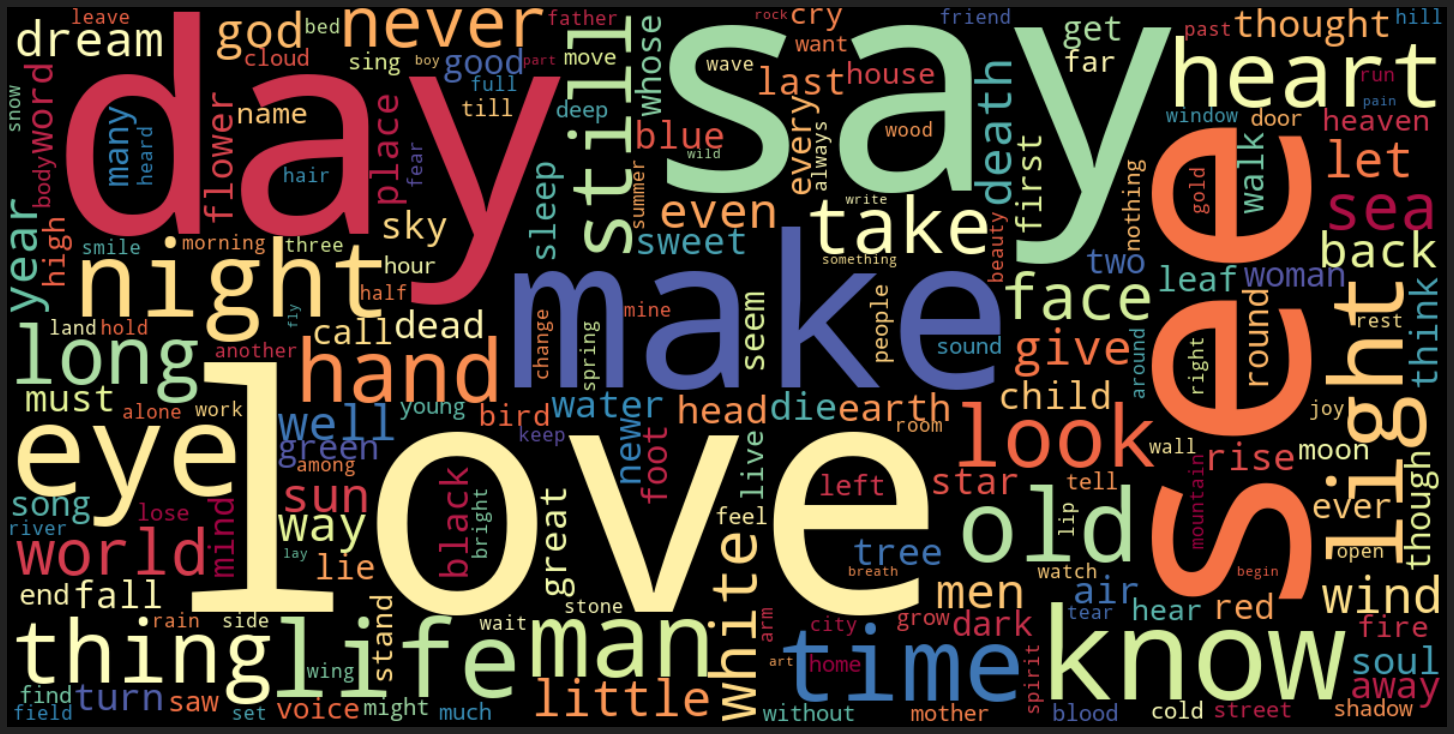

In [93]:
# create a dictionary for easy word cloud creation
word_dict = dict(Counter(all_words2))

# create word cloud
wordcloud = WordCloud(colormap='Spectral', width=1200, height=600).generate_from_frequencies(word_dict)

# plot word cloud
plt.figure(figsize=(20,10), facecolor='k')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)

## Word clouds by genre

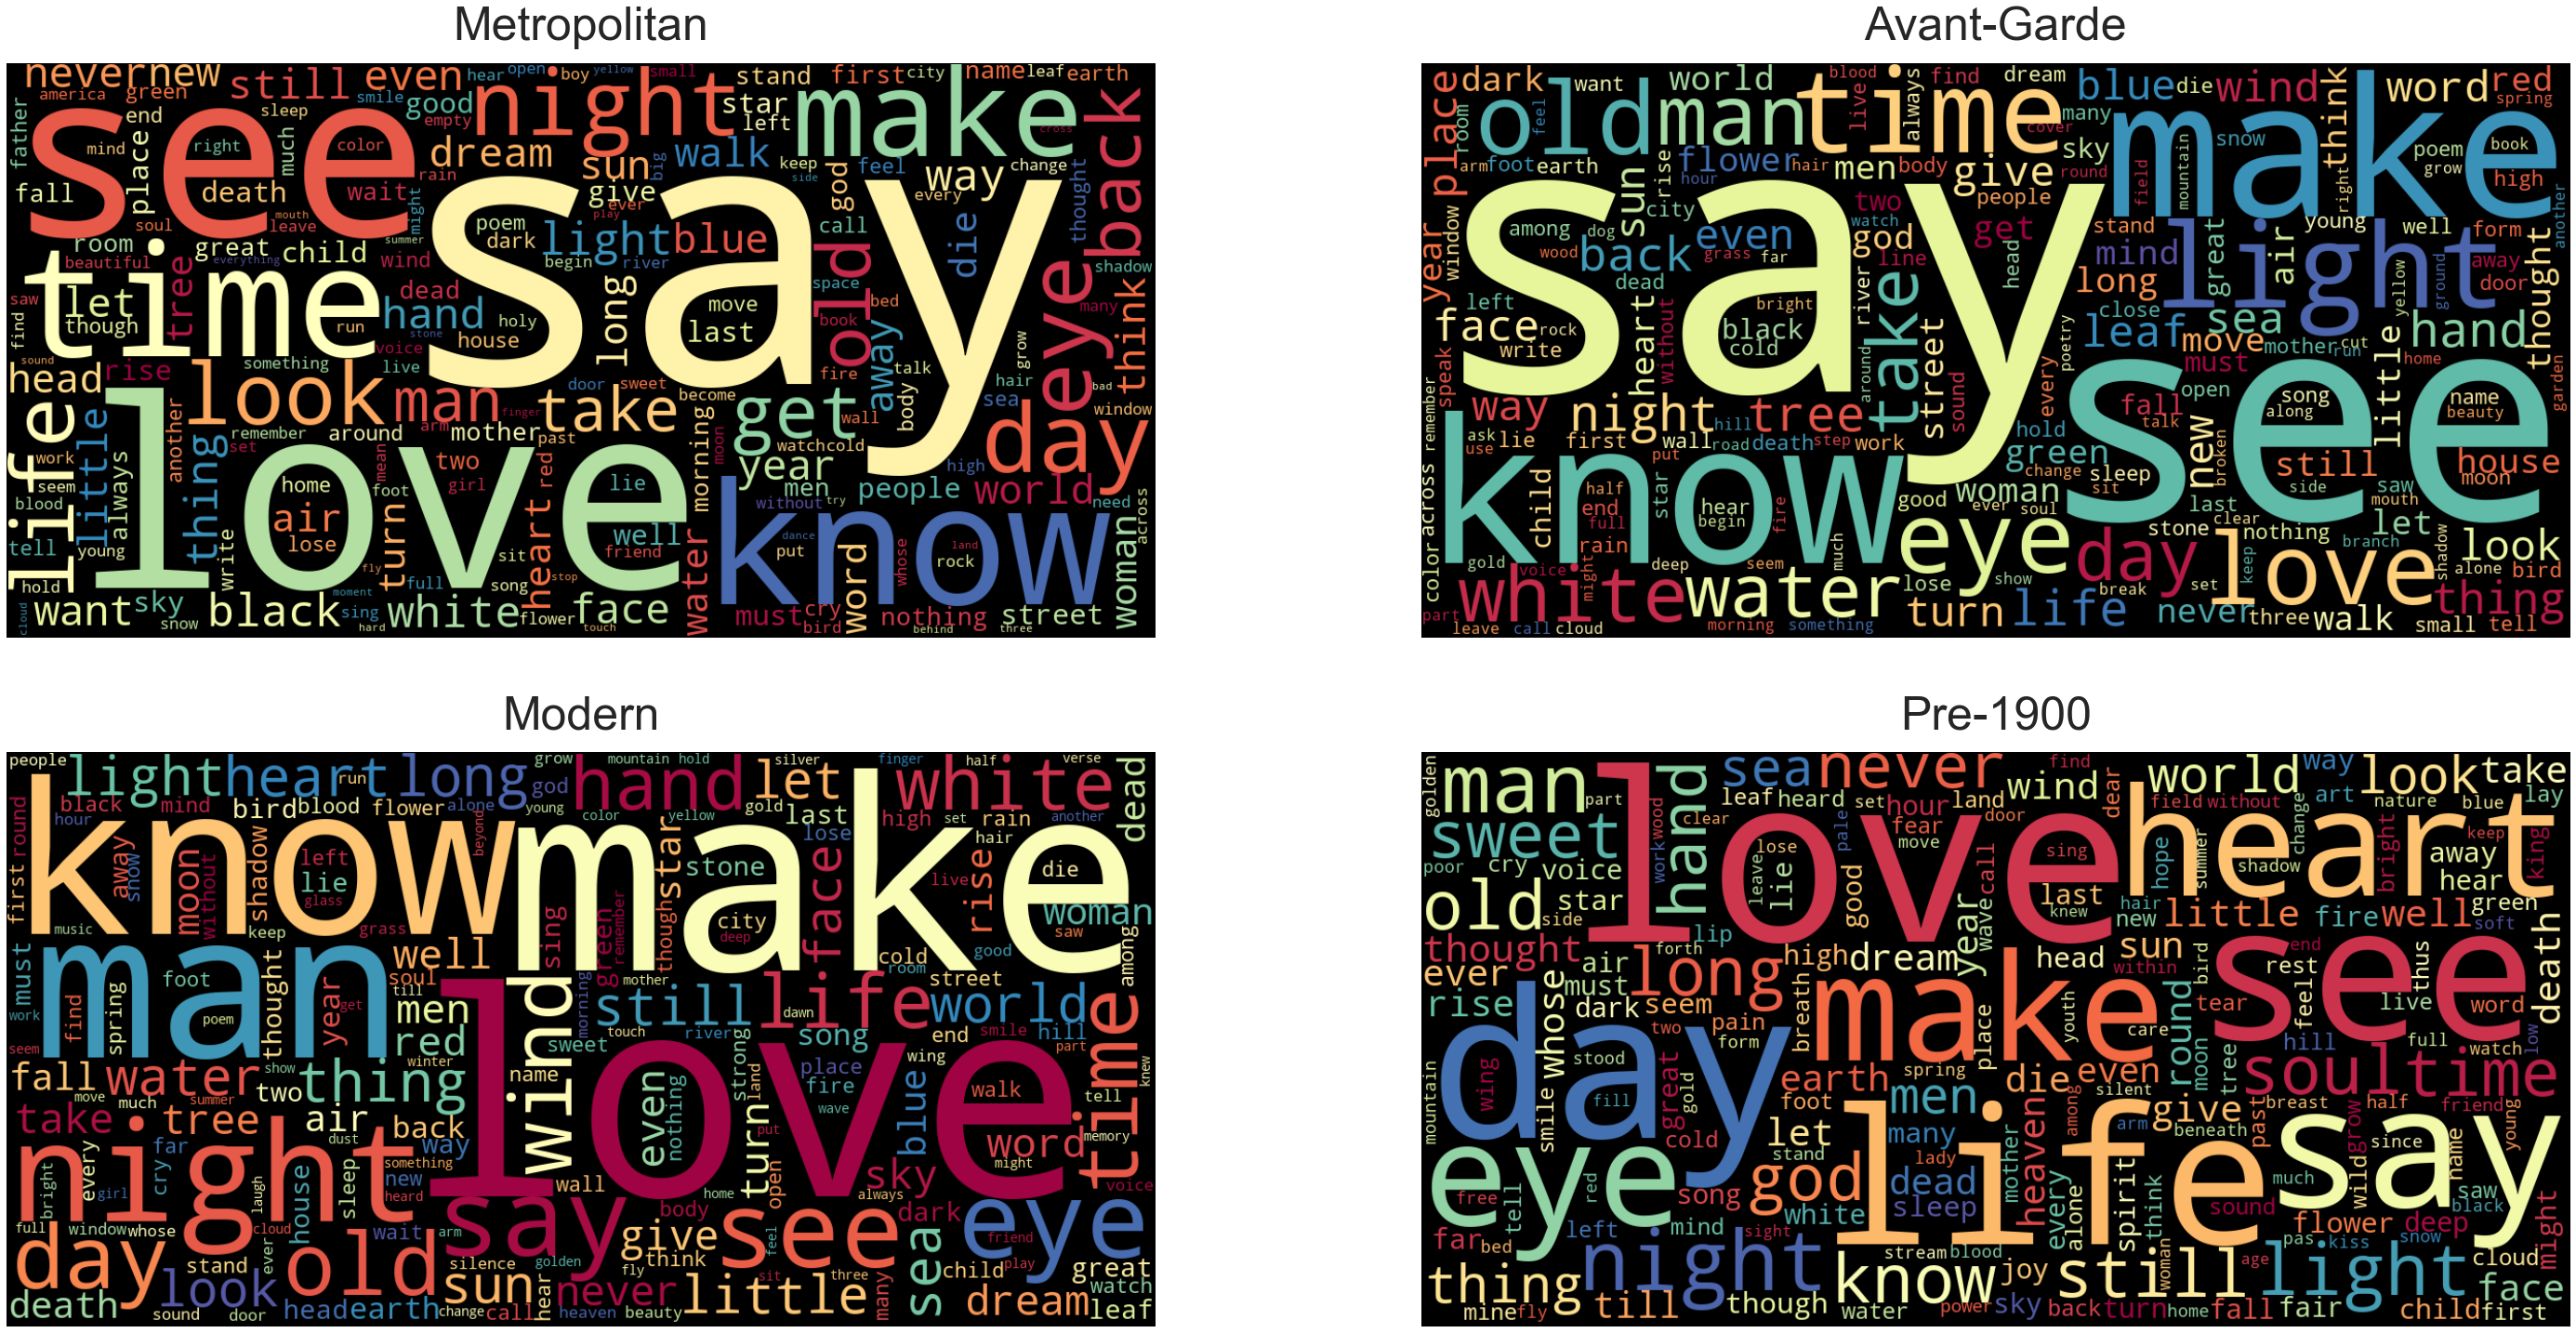

In [100]:
plt.figure(figsize=(50,25))

genres = list(df.genre.unique())

for i, genre in enumerate(genres):
    # create a series of processed poem strings
    genre_string_series = df[df.genre == genre].string_cleaned
    
    # convert the series to one big string
    genre_big_string = ' '.join(genre_string_series)
    
    # split the big string so we get all words in the genre
    genre_words = genre_big_string.split()
    
    # create a dictionary for easy word cloud creation
    genre_word_dict = dict(Counter(genre_words))

    # create word cloud
    genre_wordcloud = WordCloud(colormap='Spectral', width=1200, height=600).\
                                                        generate_from_frequencies(genre_word_dict)

    nrows = 2
    ncols = 2

    plt.subplot(nrows, ncols, i+1)
    plt.plot()
    plt.imshow(genre_wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'{genre.title().replace("_", "-")}', fontsize=50, pad=25)

## SAVE/LOAD -- Numerical features DataFrame
#### NOTE: I'll be pickling now to avoid having to destringify columns

In [106]:
# # uncomment to save
# with gzip.open('data/poetry_umbrella_genres_df.pkl', 'wb') as goodbye:
#     pickle.dump(df, goodbye, protocol=pickle.HIGHEST_PROTOCOL)
    
# # uncomment to load
# with gzip.open('data/poetry_umbrella_genres_df.pkl', 'rb') as hello:
#     df = pickle.load(hello)

In [107]:
df.columns

Index(['poet_url', 'poem_url', 'poet', 'title', 'poem_lines', 'poem_string',
       'genre', 'clean_lines', 'num_lines', 'num_words', 'avg_len_line',
       'sentiment_polarity_score', 'sentiment_polarity',
       'sentiment_subjectivity_score', 'num_end_rhymes', 'end_rhyme_ratio',
       'end_rhyme', 'num_syllables', 'avg_syllables_word', 'lines_titled',
       'string_titled', 'string_cleaned'],
      dtype='object')

### Scatter matrix, to help limit features in later notebooks

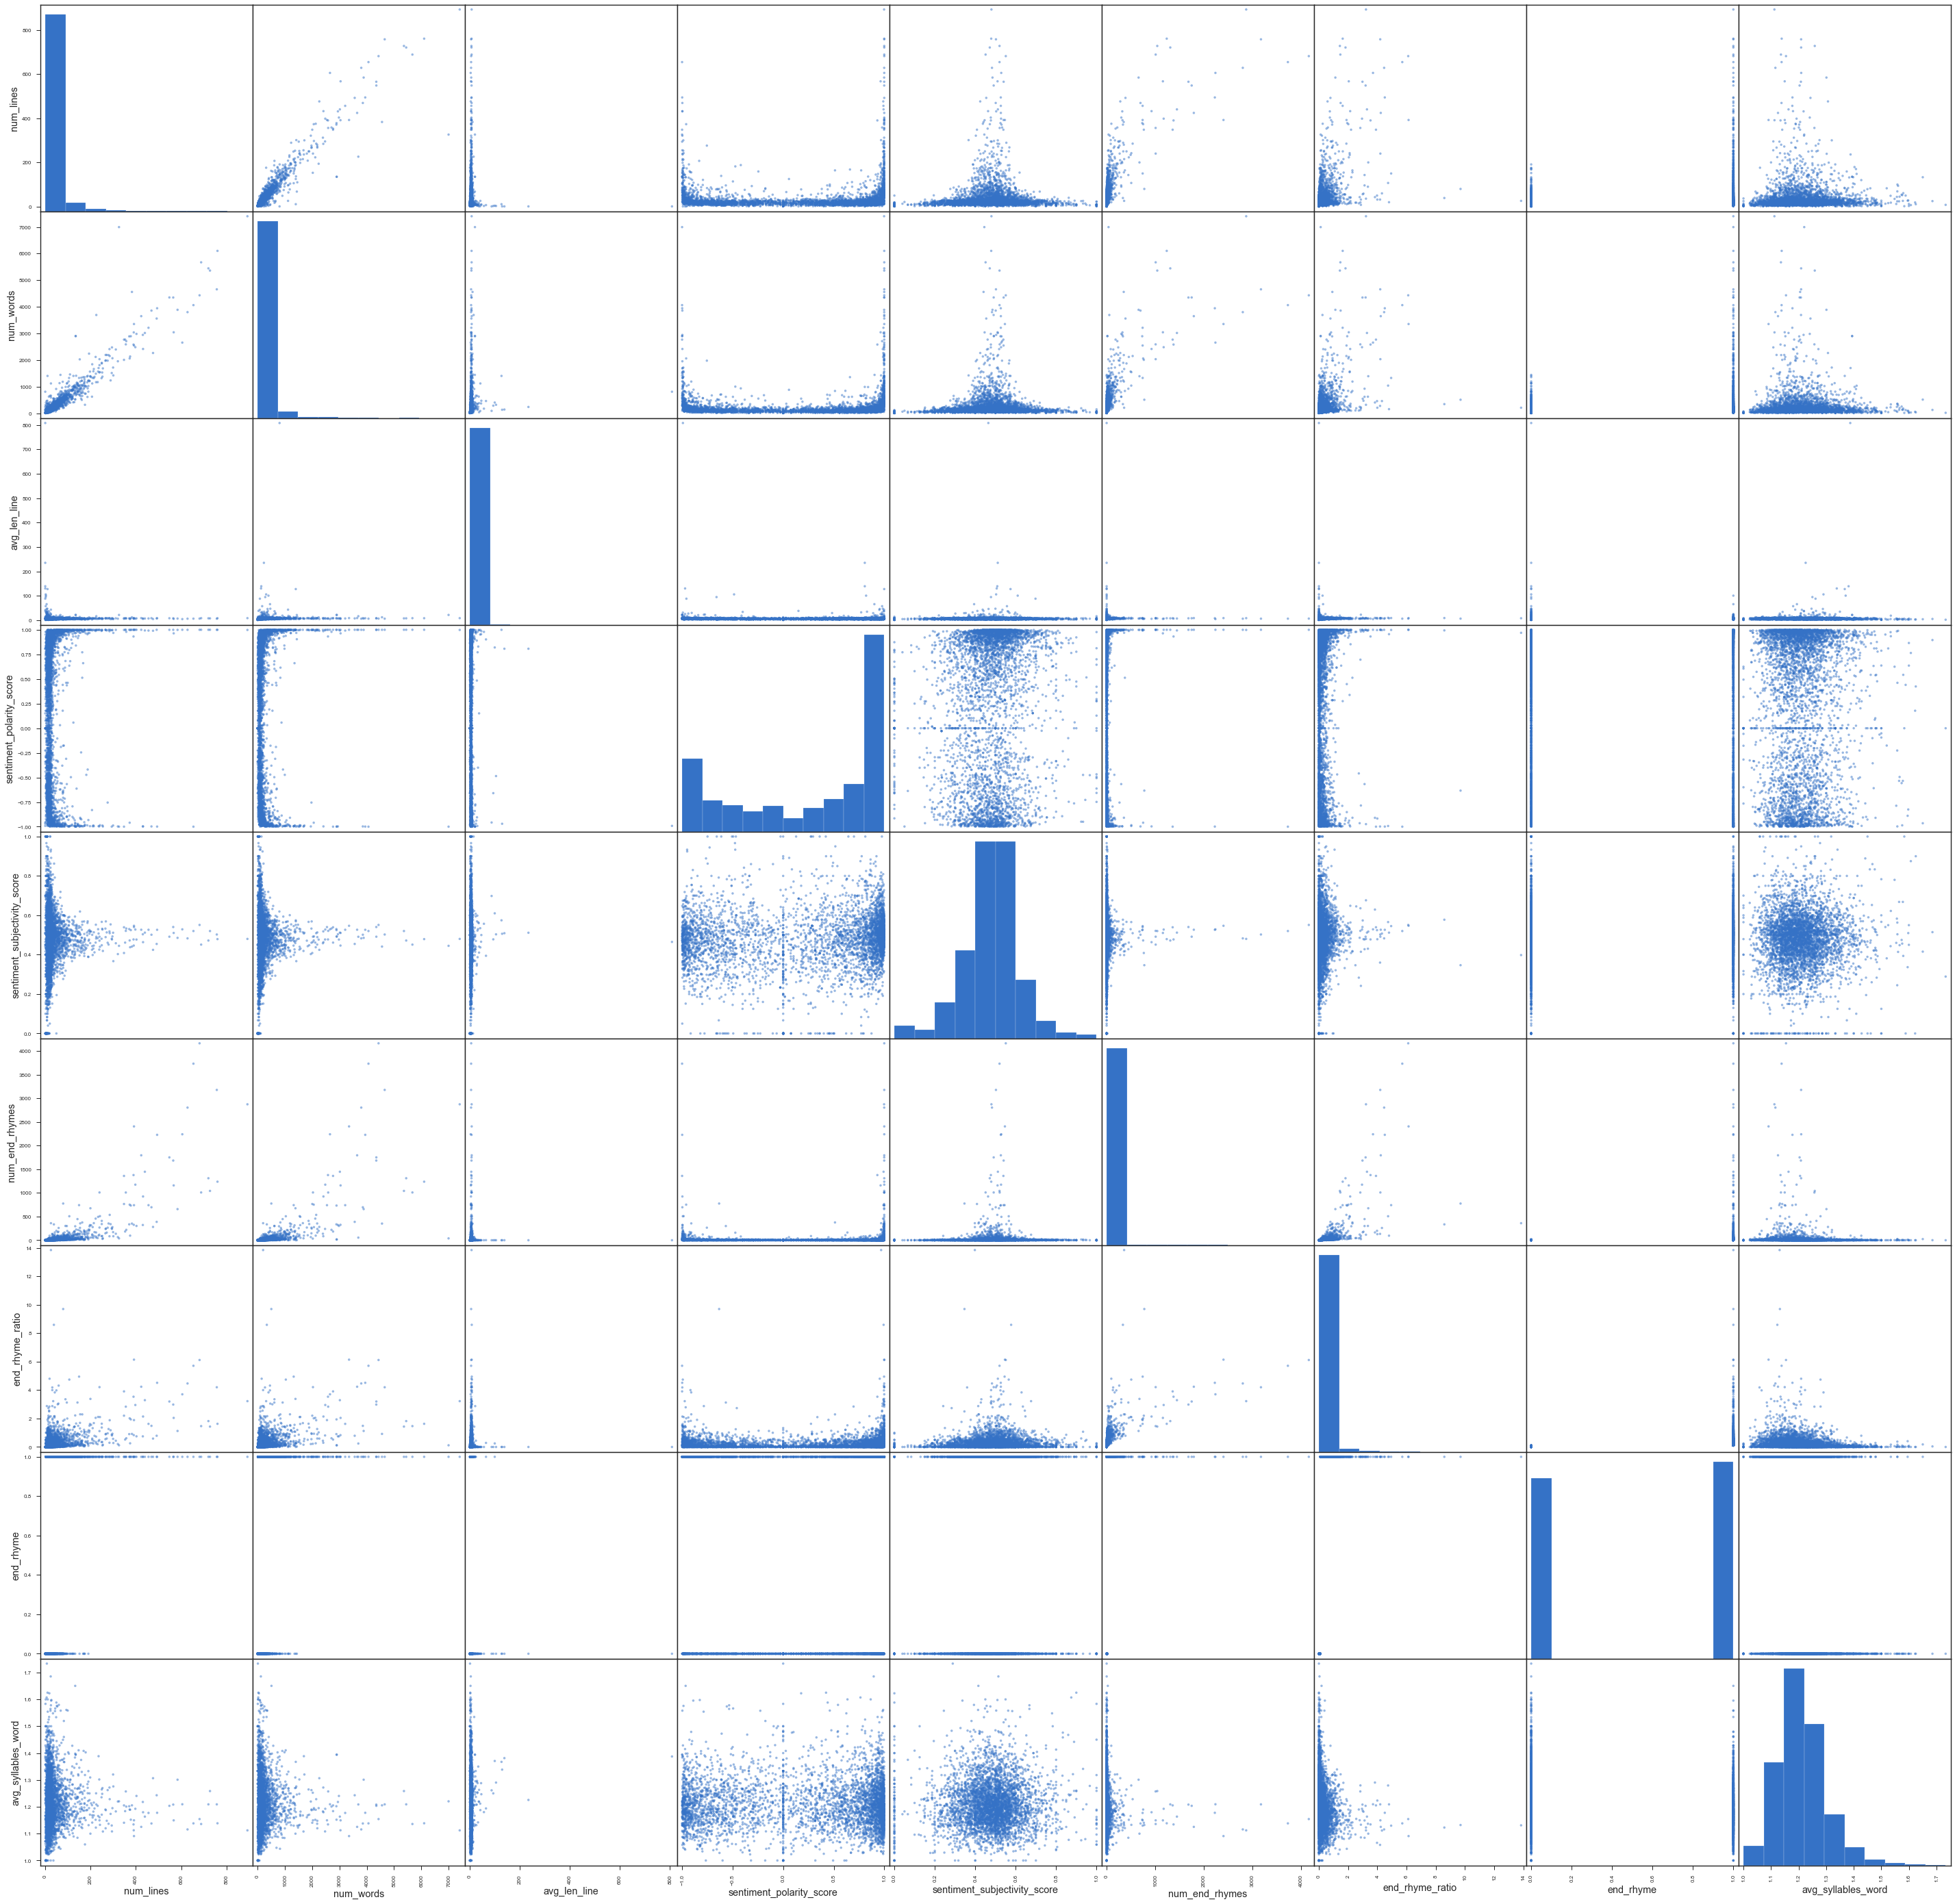

In [109]:
pd.plotting.scatter_matrix(df[['num_lines', 'num_words', 'avg_len_line', 'sentiment_polarity_score',
                               'sentiment_polarity', 'sentiment_subjectivity_score', 'num_end_rhymes', 
                               'end_rhyme_ratio', 'end_rhyme', 'avg_syllables_word']], 
                           figsize=(50,50));

## Modeling Prep
### Removing outliers/capping values so they don't throw off our scaler
#### Number of lines

In [189]:
df_edit = df.copy()

In [190]:
df_edit.num_lines.describe()

count    4376.000000
mean       35.506170
std        58.407807
min         1.000000
25%        14.000000
50%        21.000000
75%        32.000000
max       892.000000
Name: num_lines, dtype: float64

In [191]:
df_edit[df_edit.num_lines < 90].num_lines

0        4
1       17
2        6
3       17
4        4
        ..
4368    72
4369    42
4372    56
4373    44
4374    40
Name: num_lines, Length: 4090, dtype: int64

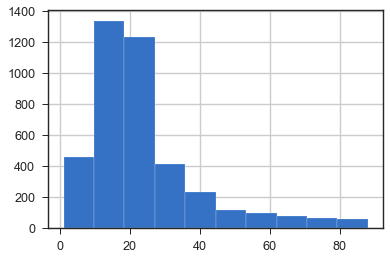

In [192]:
df_edit[df_edit.num_lines < 90].num_lines.hist()

In [193]:
df_edit['num_lines'] = np.where(df_edit.num_lines > 90, 90, df_edit.num_lines)

#### Number of words

In [194]:
df.num_words.describe()

count    4376.000000
mean      233.031536
std       436.410862
min         2.000000
25%        82.000000
50%       124.000000
75%       210.000000
max      7405.000000
Name: num_words, dtype: float64

In [195]:
df[df.num_words < 700].num_words

0        24
1        45
2        33
3        54
4        13
       ... 
4369    394
4370    671
4372    393
4373    279
4374    230
Name: num_words, Length: 4147, dtype: int64

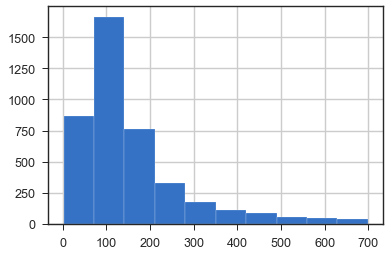

In [196]:
df[df.num_words < 700].num_words.hist()

In [197]:
df_edit['num_words'] = np.where(df_edit.num_words > 700, 700, df_edit.num_words)

#### Average words per line

In [198]:
df[df.avg_len_line < 12].avg_len_line

0       6.000000
1       2.647059
2       5.500000
3       3.176471
4       3.250000
          ...   
4371    6.153236
4372    7.017857
4373    6.340909
4374    5.750000
4375    6.214067
Name: avg_len_line, Length: 4295, dtype: float64

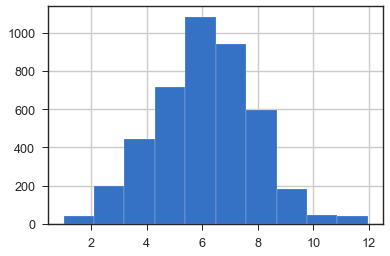

In [199]:
df[df.avg_len_line < 12].avg_len_line.hist()

In [200]:
df_edit['avg_len_line'] = np.where(df_edit.avg_len_line > 12, 12, df_edit.avg_len_line)

#### Number of end rhymes

In [201]:
df_edit.num_end_rhymes.describe()

count    4376.000000
mean       23.887797
std       158.125011
min         0.000000
25%         0.000000
50%         3.000000
75%         9.000000
max      4165.000000
Name: num_end_rhymes, dtype: float64

In [202]:
df_edit[df_edit.num_end_rhymes < 50].num_end_rhymes

0        0
1        0
2        1
3        0
4        0
        ..
4367     9
4369    26
4372    36
4373    18
4374    17
Name: num_end_rhymes, Length: 4118, dtype: int64

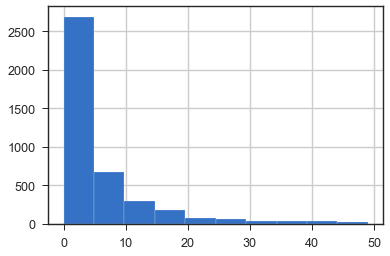

In [203]:
df_edit[df_edit.num_end_rhymes < 50].num_end_rhymes.hist()

In [204]:
df_edit['num_end_rhymes'] = np.where(df_edit.num_end_rhymes > 50, 50, df_edit.num_end_rhymes)

#### End rhyme ratio

In [205]:
df_edit.end_rhyme_ratio.describe()

count    4376.000000
mean        0.284815
std         0.552117
min         0.000000
25%         0.000000
50%         0.115069
75%         0.375000
max        13.846154
Name: end_rhyme_ratio, dtype: float64

In [206]:
df_edit[df_edit.end_rhyme_ratio < 1].end_rhyme_ratio

0       0.000000
1       0.000000
2       0.166667
3       0.000000
4       0.000000
          ...   
4368    0.708333
4369    0.619048
4372    0.642857
4373    0.409091
4374    0.425000
Name: end_rhyme_ratio, Length: 4141, dtype: float64

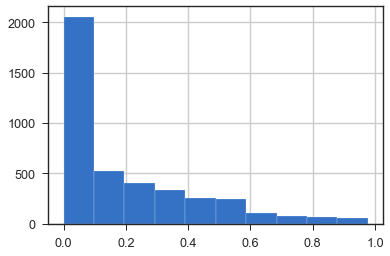

In [207]:
df_edit[df_edit.end_rhyme_ratio < 1].end_rhyme_ratio.hist()

In [208]:
df_edit['end_rhyme_ratio'] = np.where(df_edit.end_rhyme_ratio > 50, 50, df_edit.end_rhyme_ratio)

## SAVE/LOAD -- EDITED Numerical features DataFrame

In [214]:
# # uncomment to save
# with gzip.open('data/poetry_umbrella_genres_df_edit.pkl', 'wb') as goodbye:
#     pickle.dump(df_edit, goodbye, protocol=pickle.HIGHEST_PROTOCOL)
    
# # uncomment to load
# with gzip.open('data/poetry_umbrella_genres_df_edit.pkl', 'rb') as hello:
#     df = pickle.load(hello)